# 1. K-Nearest Neighbors

## 1.1. The algorithm
[K-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) ($K$-Nearest Neighbors) does not actually *learn* anything, it only *saves* all training data point. When predicting the label for a new query point $\mathbf{o}_q$, the model first measures the distance $d_n$ from each training point $\mathbf{o}_n$ ($n=1,2,\dots,N$) to $\mathbf{o}_q$. Then, selects $K$ points with smallest distance and do majority/weighted voting to determine which class the query point belongs to. For weighted voting, the query point will fall into the class with the highest total of weight. The corresponding weight of the observation $\mathbf{o}_k$ is $\displaystyle{w_k=1/d_k}$ ($k=1,2,\dots,K$). Majority voting can be thought as weighted voting where all sample weights are set to $1/K$.

K-NN can also predict the probability that the query point falls into a specific class by computing the ratio between the total weights of those neighbors who support that class over the total weights of all $K$ neighbors.

### Distance metrics
Some popular [distance metrics](<https://en.wikipedia.org/wiki/Metric_(mathematics)>) being used in K-NN are:
- [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), measures the total distance of going along side every axis.
- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), measures the direct distance.
- [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), same as Euclidean but variables are scaled and transformed to be uncorrelated.
- [Cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity), measures how large the angle between two vectors is.

However, Euclidean distance is the most common method:

$$d_n = \sqrt{(x_{1n}-x_{1q})^2+(x_{2n}-x_{2q})^2+\dots}$$

## 1.2. Implementation

### Hyperparameters
Notable hyperparameters in the
<code><a style="font-size:12px" href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">KNeighborsClassifier</a></code>
class are:
- <code style="font-size:12px; color:#BA2121;">n_neighbors</code>: the number of neighbors who vote for the label ($K$), defaults to *5*.
- <code style="font-size:12px; color:#BA2121;">weights</code>: the voting strategy, defaults to *uniform* (majority voting). Can be set to *distance* for weighted voting.
- <code style="font-size:12px; color:#BA2121;">metrics</code>: the type of distance metric, defaults to *euclidean*. Other options are *manhattan*, *mahalanobis*, *minkowski* and *chebyshev*. Also accepts customized metrics with the signature
<code style="font-size:12px">funcDistance(x, y) -> distance</code>,
beside [bulit-in ones](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html).

In [14]:
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, fbeta_score
from sklearn.metrics.pairwise import paired_cosine_distances, cosine_distances

In [2]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=1)

In [22]:
start = dt.datetime.now()

def cosine_distance(x, y):
    from numpy.linalg import norm
    return 1 - x @ y / (norm(x, 2) * norm(y, 2))

space1 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': [cosine_distance],
}

space2 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['mahalanobis'],
    'metric_params': [{'VI': np.cov(xTrain)}]
}

space3 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2, 3, 4, 5],
}

params = [space1, space2, space3]

algo = KNeighborsClassifier()
validator = GridSearchCV(algo, params, cv=5, scoring='roc_auc')
validator = validator.fit(xTrain, yTrain)
model = validator.best_estimator_

end = dt.datetime.now()
print(end - start)

0:00:44.585103


In [30]:
validator.best_params_

{'metric': 'minkowski', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [21]:
yTestPred = model.predict(xTest)
aucTest = roc_auc_score(yTest, yTestPred)
modelName = model.__class__.__name__

print(f'AUC = {aucTest:.4f} [{modelName}]')

AUC = 0.9216 [KNeighborsClassifier]


### Model structure
Here are the information you can extract from a K-NN model fit by Scikit-learn:
- <code style="font-size:12px"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors">kneighbors()</a></code>
method: find the $K$ neighbors and their corresponding distances of query points.
- <code style="font-size:12px"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors_graph">kneighbors_graph()</a></code>
method: compute the weighted graph of $K$ neighbors for query points.

In [25]:
neighborDistance, neighborIndex = model.kneighbors(xTest)
neighborDistance.shape

(114, 9)

In [31]:
graph = model.kneighbors_graph(xTest, mode='distance').toarray()
graph.shape

(114, 455)

# 2. Decision Tree

## 2.1. The algorithm
[Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) is a method aiming to find a set of if-else statements work as a preditive model, visualized as a hierarchy diagram. There has been several Decision Tree algorithms invented throught out the history, notably include:
- [ID3](https://en.wikipedia.org/wiki/ID3_algorithm), an algorithm that creates a multiway classification tree using [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees) principle and works only on categorical variables.
- [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm), the successor of ID3, makes a number of improvements: (1) accepting continuous variables using thresholds, (2) ignoring missing values in the calculation of information gain and (3) introducing tree pruning.
- [CART](<https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_(CART)>), a similar algorithm to C4.5 but it only grows binary trees and supports regression problems. This is the algorithm used in Scikit-learn.

### Components of a tree
In a Decision Tree, a node is the representation of data. The data is then split using a variable and a split condition. A node is a parent node if it is split, the smaller nodes after splitting it are child nodes. Here are the components of a tree:
- Root node: the topmost node, represents the entire data
- Leaf node (terminal node): the node that is not split further and predicts the label
- Internal node: any node other than leaf nodes
- Edge: the specific criterion to split a node
- Branch: represents a sub-tree which considers an internal node as root node

<img src='image/tree_components.png' style='height:200px; margin:auto;'>

### Measures of impurity
The ultimate goal of Decision Tree is to construct a tree having leaf nodes as *pure* as possible. A node is considered *pure* if most of its observations fall into a single class. In contrast, an *impure* node distributes its observations equally into different classes. In this section, we learn about some quality metrics which measure the *impurity* of a node. These metrics should be designed so that the higher values they are, the less pure a node is.

Let's say at a node, the probability (ratio) that an observation falls into a class $C_i$ is $p_i$. Here are the two measures of impurity:

- $\displaystyle{\mbox{Entropy} = -\sum{p_i\ln{p_i}}}$

- $\displaystyle{\mbox{Gini} = 1-\sum{p_i^2}}$

Now let's graph these functions for the most simple case: binary classification. Despite that there are 2 classes, we only need to plot against the ratio of positive class.

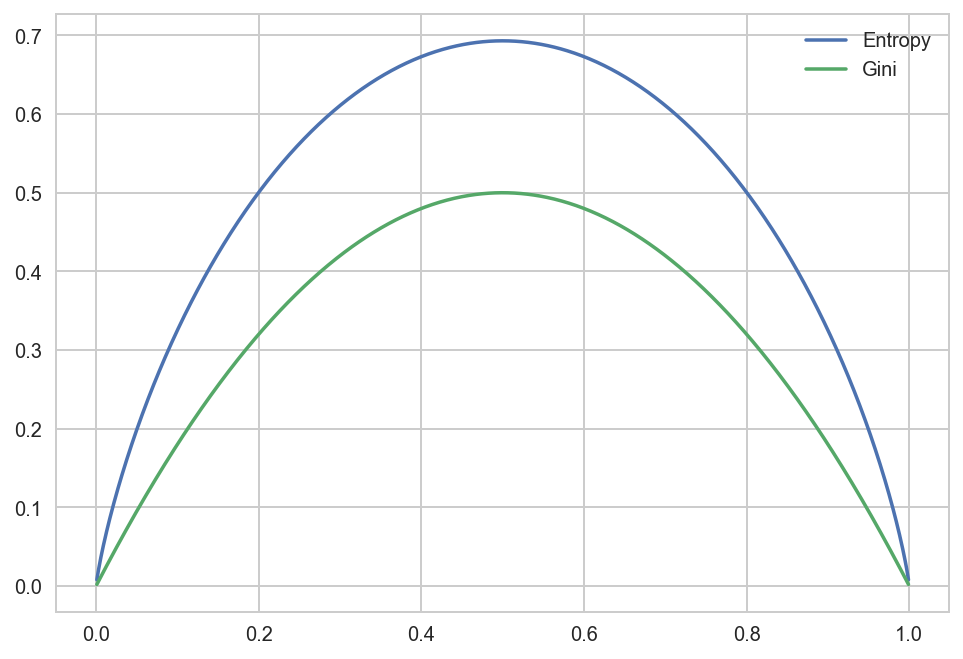

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

error = 1e-3
boundLeft, boundRight = 0, 1
boundLeft, boundRight = boundLeft + error, boundRight - error

p = np.linspace(boundLeft, boundRight, 1000)
q = 1 - p

entropy = -(p * np.log(p) + q * np.log(q))
gini = 1 - (p**2 + q**2)

fig, ax = plt.subplots()
ax.plot(p, entropy, label='Entropy')
ax.plot(p, gini, label='Gini')
ax.legend()
plt.show()

### Recursive splitting
The overall idea of Decision Tree is to decide which variable and threshold should be used in splitting data at each node. We would expect a split should results in pure/homogeneous child nodes, since it will be much easier to classify data in such leaves.
- Starting at the root node, the algorithm looks for the best candidate ()

a variable that best splits the data. Consider a candidate $\mathbf{x}$, possible values of $\mathbf{x}$ are $x_1,x_2,\dots$ The split of $\mathbf{D}$ on $\mathbf{x}$ (denoted $\mathbf{D}|\mathbf{x}$) outputs child nodes $\mathbf{D}|x_1,\mathbf{D}|x_2,\dots$
- Measure the impurity for each candidate, using Entropy or Gini index. The split with the lowest impurity will be chosen.
- This procedure is recursively repeated until all leaf nodes are pure enough to classify. A couple of stopping criteria can be added to prevent the tree from being too complex, which may cause overfitting.

### Algorithm details
*Input*
- A dataset of numerical features
- A quality function 
- Stopping criteria (optional)

For each unsplit node $D$ (starting from the root node):
- *Step 1*. Compute the impurity of node $D$, denoted $I_0$.
- *Step 2*. For each candiate (which is a combination a feature and a threshold):
    - Split node $D$ into 2 smaller nodes, $D_1$ and $D_2$.
    - Calculate the impurity for these child nodes, denoted $I_1$ and $I_2$.
    - Calculate the information gain for the candidate:
    
    $$\text{Gain}=I_0-\left(\frac{|D_1|}{|D|}I_1+\frac{|D_2|}{|D|}I_2\right)$$
    
- *Step 3*. Choose the candidate with the highest information gain. Split node $D$ using that candidate.

## 2.2. Implementation
Notable hyperparameters in the
<code><a style="font-size:12px" href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a></code>
class are:
- <code style="font-size:12px; color:#BA2121;">criterion</code>: the measure of quality of a split, defaults to *gini*. The other option is *entropy*.
- <code style="font-size:12px; color:#BA2121;">max_depth</code>: the maximum depth of the tree, defaults to *None* (no limitations).
- <code style="font-size:12px; color:#BA2121;">max_leaf_nodes</code>: the maximum number of leaf nodes, defaults to *None* (no limitations).
- <code style="font-size:12px; color:#BA2121;">min_samples_split</code>: the minimum ratio number (if integer) or (if float) of instances in a node to split, defautls to *2*.
- <code style="font-size:12px; color:#BA2121;">min_samples_leaf</code>: the minimum number (integer) or ratio (float) of instances a node must have, deafaults to *1*.
- <code style="font-size:12px; color:#BA2121;">min_weight_fraction_leaf</code>: the minimum sum of instance weights a node must have, defaults to *0*.
- <code style="font-size:12px; color:#BA2121;">min_impurity_decrease</code>: a split will be performed if its information gain is not less than this value, defaults to *0*.

In [126]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, fbeta_score

In [127]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=1)

In [128]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,6),
    'random_state': [2],
}

model = DecisionTreeClassifier()
model = GridSearchCV(model, params, cv=5, scoring='roc_auc')
model = model.fit(xTrain, yTrain)

model.best_params_

{'criterion': 'gini', 'max_depth': 4, 'random_state': 2}

In [129]:
yTestPred = model.predict(xTest)
aucTest = roc_auc_score(yTest, yTestPred)
modelName = model.best_estimator_.__class__.__name__

print(f'AUC = {aucTest:.4f} [{modelName}]')

AUC = 0.9266 [DecisionTreeClassifier]


In [ ]:
model.

### Feature importances

### Interpreting
A max depth of 3 is selected for better visualization. Each color represents a class, dark color nodes are the purest ones. In contrast, it's very hard to make a decision for bright nodes.

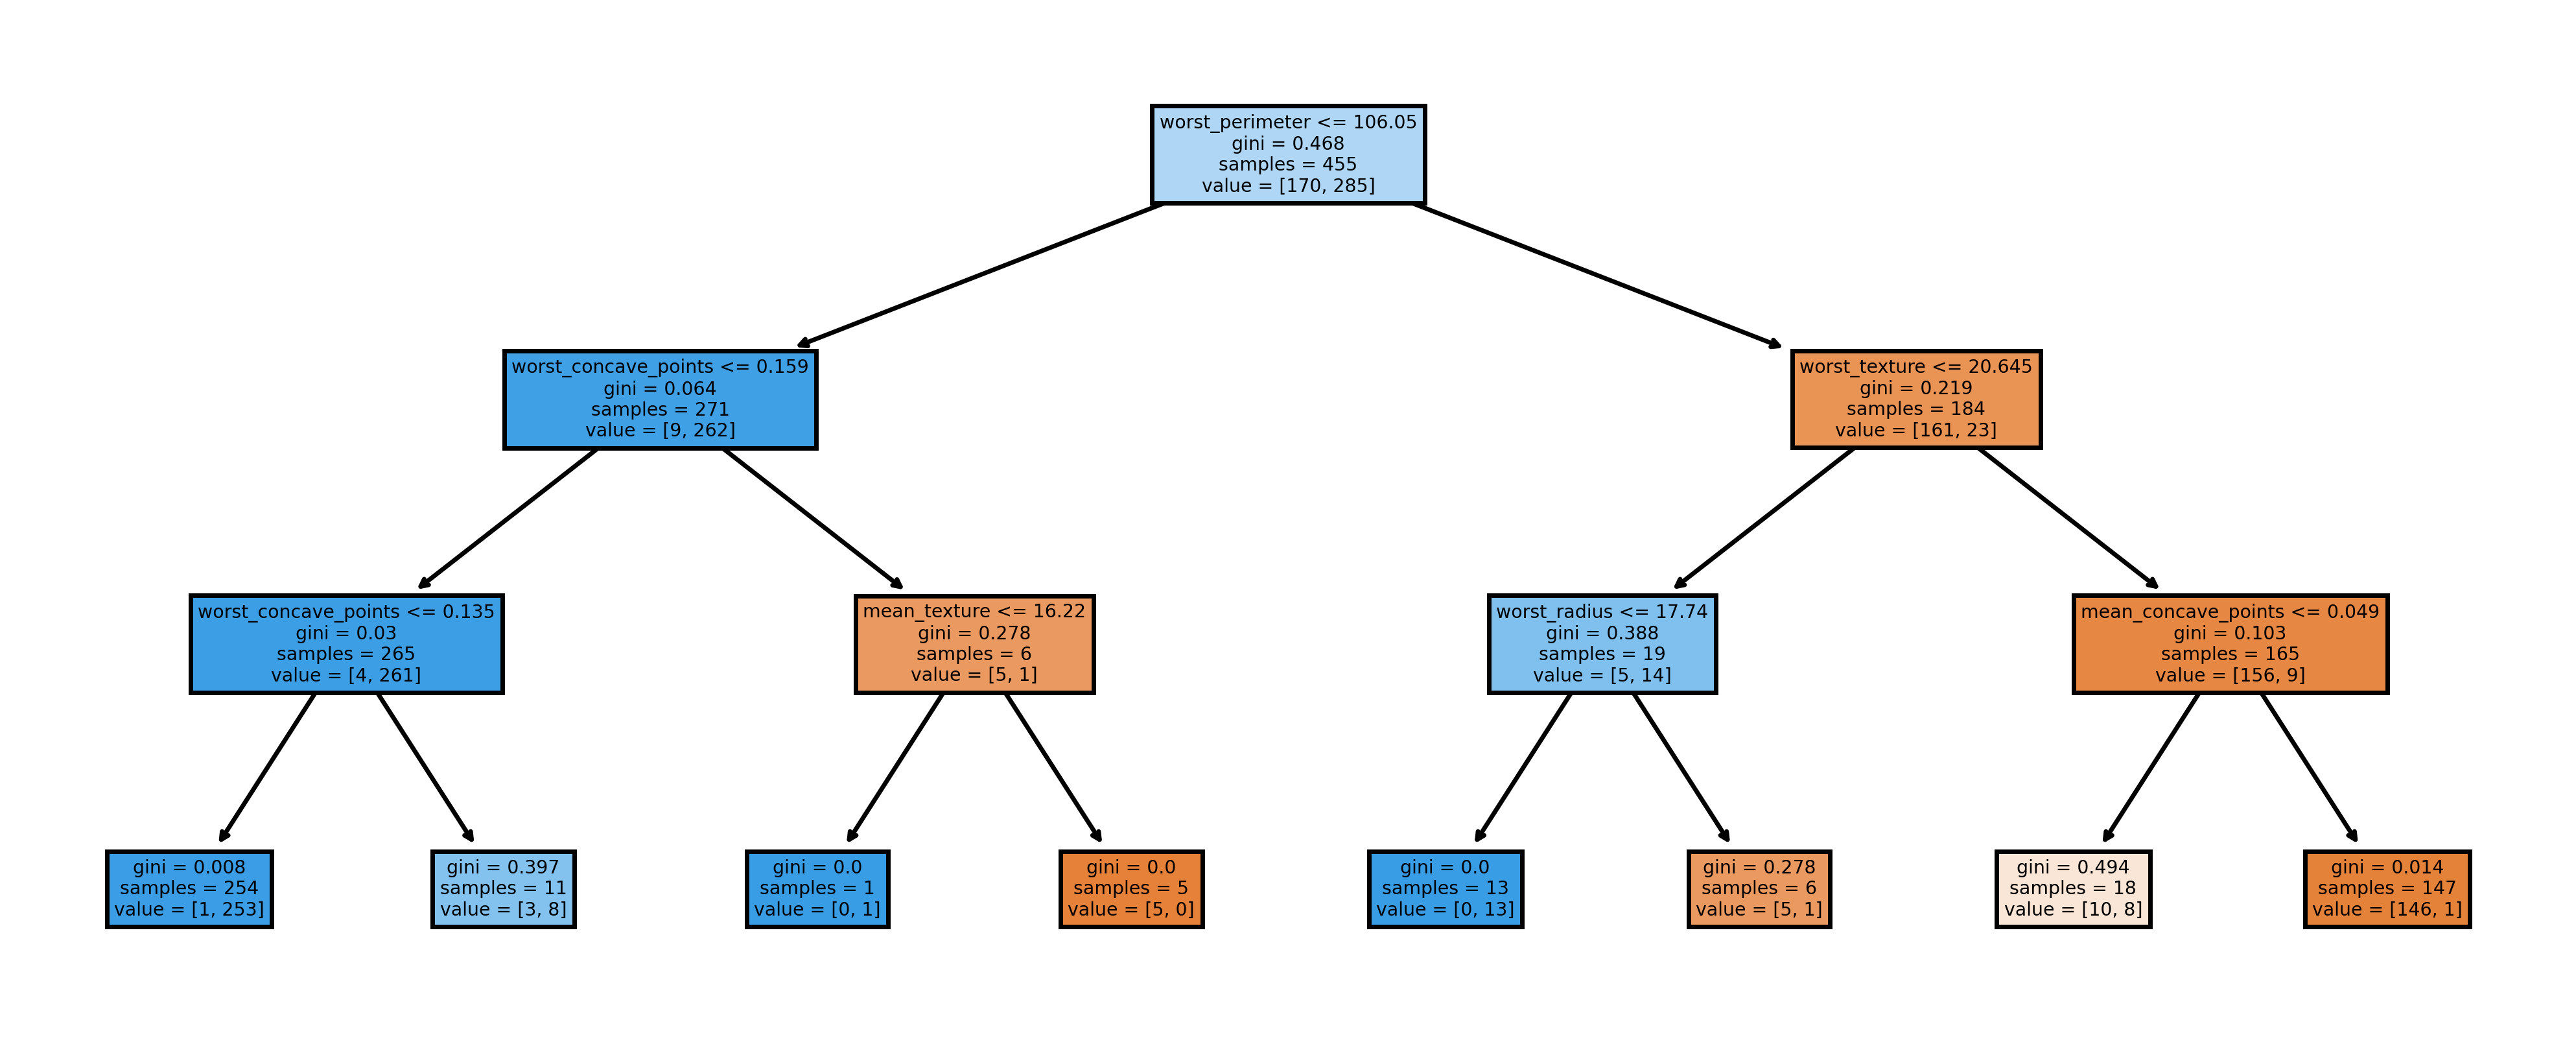

In [125]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree = tree.fit(xTrain, yTrain)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4), dpi=500)
plot_tree(tree, feature_names=tree.feature_names_in_, filled=True)
plt.show()

# 3. Naive Bayes

## 3.1. The algorithm
[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) is an algorithm based on the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). In the context of classification, given $\mathbf{X}=\mathbf{x}_1,\mathbf{x}_2,\dots$ is the set of input variables and $\mathbf{y}$ is the output variable; the Bayes theorem can be written as:

$$P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})}$$

- $P(\mathbf{y}|\mathbf{X})$ is the posterior probability, the probability of a class for given predictors
- $P(\mathbf{X}|\mathbf{y})$ is the likelihood, the probability of predictors for a given class
- $P(\mathbf{y})$ is the prior probability of a class
- $P(\mathbf{X})$ is the prior probability of predictors

This formula expresses how the algorithm classifies a new query point to the class $c$:

$$\hat{\mathbf{y}} = \arg\max P(\mathbf{y}=c|\mathbf{X}) =
\arg\max P(\mathbf{X}|\mathbf{y}=c)P(\mathbf{y}=c)$$

### Estimating the likelihood
Naive Bayes assumes that $\mathbf{x}_1,\mathbf{x}_2,\dots$ are independent of each other. This assumption looks quite unrealistic, explains why the algorithm is considered naive. However, Naive Bayes performs surprisingly well in real-world classification problems. The likelihood can be written under this assumption:

$$P(\mathbf{x}_1,\mathbf{x}_2,\dots|\mathbf{y}) = \prod{P(\mathbf{x}_i|\mathbf{y})}$$

To estimate $P(\mathbf{x}_i|\mathbf{y})$, there are three distributions can be used, depending on the input data:
- Gaussian distribution, used when the input data is continuous. The parameters $\mu_{\mathbf{y}}$ and $\sigma_{\mathbf{y}}$ are estimated using maximum likelihood.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathbf{y}}}} \exp\left(-\frac{(\mathbf{x}_i - \mu_{\mathbf{y}})^2}{2\sigma^2_{\mathbf{y}}}\right)$$

- Multinomial distribution, used when the input data is categorical data. Widely used in text classification. In this formula, $N$ represents the number of observations, $\alpha$ represents the Laplace smooth coefficient, $d$ is the number of words. $\alpha=1$ is usually chosen, prevents the probability to be 0.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{N(\mathbf{x}_i|\mathbf{y})+\alpha}{N(\mathbf{y})+\alpha d}$$

- Bernoulli distribution, used for binary input data.

$$P(\mathbf{x}_i|\mathbf{y}) = p_i^{\mathbf{x}_i}(1-p_i)^{1-\mathbf{x}_i}$$

## 3.2. Implementation

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

### Tabular data
This section uses the Iris data, where input variables are continuous. For a mixed types dataset, we use `GaussianNB` for continuous input and `MultinomialNB` for categorical input, then multiply the predicted probability of each class.

In [21]:
iris = load_iris()
x = iris.data
y = iris.target

In [22]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=1)

In [23]:
bayes = GaussianNB()
bayes = bayes.fit(xTrain, yTrain)

In [24]:
yTrainPred = bayes.predict(xTrain)
yTestPred = bayes.predict(xTest)

In [25]:
print(classification_report(yTrain, yTrainPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.94      0.91      0.92        32
           2       0.92      0.95      0.93        37

    accuracy                           0.95       105
   macro avg       0.95      0.95      0.95       105
weighted avg       0.95      0.95      0.95       105



In [26]:
print(classification_report(yTest, yTestPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.89      0.91        18
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



### Text data
Text data is preprocessed so that each column represents a word, each row represents a graph. This table shows how many times a word occurs in a graph. Then apply `MultinomialNB`.

In [27]:
xTrain = np.array([
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 3, 0, 1, 2, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 2, 1, 1]
])
yTrain = np.array(['A', 'A', 'A', 'B'])

xTest = np.array([
    [1, 2, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 1]
])

In [28]:
bayes = MultinomialNB()
bayes = bayes.fit(xTrain, yTrain)

In [29]:
bayes.predict(xTest)

array(['A', 'B'], dtype='<U1')

In [30]:
bayes.predict_proba(xTest)

array([[0.93708063, 0.06291937],
       [0.34255957, 0.65744043]])

# 4. Support Vector Machines
*Reference: [Scikit-Learn - Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)*

## 4.1. The algorithm
[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#svm-classification) is a binary classification algorithm, aiming to find a hyperplane that best splits the data into two classes ($\mathbf{y}=1$ and $\mathbf{y}=-1$). SVM uses the following concepts:
- Support vector: the closest point from the separating hyperplane. There is at least one support vector in each class.
- Margin: the distance between a support vector and the separating hyperplane.

Notice that all support vectors should have the same distance from the decision boundary. In other words, the margins of both class are equal. It's quite clear to state that the larger the margin is, the better the algorithm classifies the data.

### The loss function
Assume the equation of the separating hyperplane is $w_0+w_1\mathbf{x}_1+w_2\mathbf{x}_2+\dots=0$. Denote $\mathbf{w}=(w_1,w_2,\dots)$ and $\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\dots)$, the boundary can be rewritten as $w_0+\mathbf{w}\mathbf{X}=0$. Now do some transformations so that the equations of the two edges (hyperplanes that are parallel to the boundary and go through the support vectors) are $w_0+\mathbf{w}\mathbf{X}=1$ and $w_0+\mathbf{w}\mathbf{X}=-1$.

<img src='image/svm_hard.png' style='height:300px; margin: 0 auto;'>

By assigning suitable class values (for example, $\mathbf{y}=1$ for blue class and $\mathbf{y}=-1$ for red class), we have the following important property, which becomes the constraint for the margin formula:
- $|w_0+\mathbf{w}\mathbf{X}|=\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})=1$ for support vectors
- $|w_0+\mathbf{w}\mathbf{X}|=\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})>1$ for other data points

The margin can be calculated using the formula:

$$\frac{\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})}{||\mathbf{w}||_2}
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1$$

Notice that $\mathbf{y}\;(w_0+\mathbf{w}\mathbf{X})=1$ and the objective of SVM is to maximize the margin, so the loss function is selected:

$$L(w_0,\mathbf{w}) = ||\mathbf{w}||_2
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1$$

The coefficients of the separating equation $(w_0,\mathbf{w})$ can be estimated as: $(\hat{w}_0,\hat{\mathbf{w}}) = \arg\min{L(w_0,\mathbf{w})}$.

### Soft Margin SVM
In the simple example above, the line segregates perfectly; however a hard margin like that is very sensitive to outliers and can easily lead to overfitting. This can be avoided by allowing some misclassified points to get a larger margin, and thus return a better long run performance.

To get the soft margin, we soften the constrain of the margin formula:

$$\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1-\boldsymbol{\xi}$$

$\boldsymbol{\xi}=(\xi_1,\xi_2,\dots)$ is the slack variable, which is the distance from a data point in the wrong side to its corresponding edge, and is 0 otherwise. Mathematically:
- $\boldsymbol{\xi}=0$ if a data point is in the safe zone
- $\boldsymbol{\xi}=|w_0+\mathbf{w}\mathbf{X}-\mathbf{y}|<1$ if a data point is correctly classified but lies within the margin
- $\boldsymbol{\xi}=|w_0+\mathbf{w}\mathbf{X}-\mathbf{y}|\geq1$ if a data point is in the wrong side of separating hyperplane

<img src='image/svm_soft.png' style='height:300px; margin: 0 auto;'>

The loss function of Soft Margin SVM adds a regularization amount:

$$L(w_0,\mathbf{w}) = ||\mathbf{w}||_2+C\sum{\boldsymbol{\xi}}
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1-\boldsymbol{\xi}$$

$C$ is the regularization parameter, it maintains the trade-off between the misclassifications and how large the margin is. When $C$ is very large, $\sum{\boldsymbol{\xi}}$ approaches 0, the algorithm is now using hard margin. In contrast, a small value of $C$ allows more data to be within the margin. A popular value of $C$ is $1/n$.

### Kernel SVM
Soft Margin SVM only works on linear separable data. When the data is non-linear, we project the data to a higher dimensional space. For example, mapping $(\mathbf{x}_1,\mathbf{x}_2)$ to $(\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3)$ where $\mathbf{x}_3=\mathbf{x}_1^2+\mathbf{x}_2^2$ seems a good strategy.

<img src='image/svm_kernel.png' style='height:300px; margin: 0 auto;'>

However, transforming data directly may require a lot of computation, and becomes impossible when infinite dimensional is used. This problem can be avoided thanks to a technique called the kernel trick. It calculates the dot product of two transformed vectors, which represents their relationship in higher dimensional space. Depending on the problem, there are many kernel functions can be used:
- Linear kernel: $K(\mathbf{a},\mathbf{b})=\mathbf{a}\mathbf{b}$
- Polynomial kernel: $K(\mathbf{a},\mathbf{b})=(\gamma\mathbf{a}\mathbf{b}+r)^d$
- Radial Basic Function kernel: $K(\mathbf{a},\mathbf{b})=\exp{\left(-\gamma||\mathbf{a}-\mathbf{b}||_2^2\right)}$
- Sigmoid kernel: $\tanh{(\gamma\mathbf{a}\mathbf{b}+r)}$

## 4.2. Implementation
Notable hyperparameters in [SVM implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):

Hyperparameter|Meaning|Default value|Common values|
:---|:---|:---|:---|
`C`|How significant the penalty is|`1`|`10^k` for $k\in{\{-2,-1,0,1,2\}}$|
`kernel`|The kernel function to be used|`rbf`|`rbf` `poly` `sigmoid`|
`gamma`|The parameter $\gamma$ in some kernels|`scale`|`10^k` for $k\in{\{-2,-1,0,1,2\}}$|
`coef0`|The parameter $r$ in some kernels|`0`||
`degree`|The degree $d$ in polynomial kernel|`3`||

In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
iris = load_iris()
x = iris.data
y = iris.target

In [33]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=1)

In [34]:
params = {
    'C': [0.01, 0.01, 0.1, 1, 100],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': [0.01, 0.01, 0.1, 1, 100]
}

svm = SVC()
svm = GridSearchCV(svm, params, cv=5)
svm = svm.fit(xTrain, yTrain)
svm.best_params_

{'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'}

In [35]:
yTrainPred = svm.predict(xTrain)
yTestPred = svm.predict(xTest)

In [36]:
print(classification_report(yTrain, yTrainPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.94      0.95        32
           2       0.95      0.97      0.96        37

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



In [37]:
print(classification_report(yTest, yTestPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        18
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



# 5. Multi-layer Perceptron
*Reference: [Scikit-Learn - Multi-layer Perceptron Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)*

# 6. Gaussian Process
*Reference: [Scikit-Learn - Gaussian Process Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*